In [1]:
#importing the libraries
from bs4 import BeautifulSoup
import requests
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

In [2]:
# keyword extraction https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

dataset = pd.read_csv("GustavoDeco_100papers.csv", usecols = ["Cites", "Title", "Year", "Branch", "Key words", "Abstract" ] )
dataset.head()



,Cites,Title,Year,Branch,Key words,Abstract
0,1118,Emerging concepts for the dynamical organizati...,2011,Computational and Cognitive Neuroscience,"Resting state fMRI, Psychology, Neuroscience, ...",A broad body of experimental work has demonstr...
1,794,The Dynamic Brain: From Spiking Neurons to Neu...,2008,Computational and Cognitive Neuroscience,"Working memory, Neuroscience, Mathematical the...","The cortex is a complex system, characterized ..."
2,539,"Key role of coupling, delay, and noise in rest...",2009,Computational and Cognitive Neuroscience,"Synchronization, Stochastic resonance, Statist...",A growing body of neuroimaging research has do...
3,437,Ongoing Cortical Activity at Rest: Criticality...,2012,Computational and Cognitive Neuroscience,"Resting state fMRI, Neuroscience, Multistabili...","The ongoing activity of the brain at rest, i.e..."
4,370,Stochastic dynamics as a principle of brain fu...,2009,Computational and Cognitive Neuroscience,"Recall, Probabilistic logic, Neuroscience, Neu...",The relatively random spiking times of individ...


In [3]:
# Storing the useful data from the csv into variables
citations = dataset['Cites'][:].astype(str)
titles = dataset['Title'][:].astype(str)
years = dataset['Year'][:].astype(str)
branches = dataset['Branch'][:].astype(str)
keywords = dataset['Key words'][:].astype(str)
abstracts = dataset['Abstract'][:].astype(str)


In [4]:
# Checking that y variables are correctly stored
print( citations[1] )
print( titles[1] )
print( years[1] )
print( branches[1] )
print( keywords[1] )
print( abstracts[1] )


794
The Dynamic Brain: From Spiking Neurons to Neural Masses and Cortical Fields
2008
Computational and Cognitive Neuroscience
Working memory, Neuroscience, Mathematical theory, Local field potential, Genetics, Functional magnetic resonance imaging, Electroencephalography, Computer science, Computational model, Complex system, Artificial neural networkArtificial intelligence
The cortex is a complex system, characterized by its dynamics and architecture, which underlie many functions such as action, perception, learning, language, and cognition. Its structural architecture has been studied for more than a hundred years; however, its dynamics have been addressed much less thoroughly. In this paper, we review and integrate, in a unifying framework, a variety of computational approaches that have been used to characterize the dynamics of the cortex, as evidenced at different levels of measurement. Computational models at different space–time scales help us understand the fundamental mechan

# Stopwords, stemming and tokenizing

In [5]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
print (stopwords[:10] )

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


In [6]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [7]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed


#tokenize_and_stem: tokenizes (splits the abstracts into a list of its respective words (or tokens) and also stems each token
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems



#tokenize_only: tokenizes the synopsis only
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [8]:
# Using the stemming/tokenizing functions to iterate through the abstracts to create 2 vocabularies: one stemmed and one tokenized

#not super pythonic, no, not at all.
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in abstracts:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [9]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 16423 items in vocab_frame


In [10]:
print (vocab_frame.head())
print
print
print
print

                   words
a                      a
broad              broad
bodi                body
of                    of
experiment  experimental


<function print>

# Tf-idf and document similarity


To get a Tf-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix. An example of a dtm is here at right.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document.

In [11]:

from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(abstracts) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 780 ms, sys: 11.3 ms, total: 791 ms
Wall time: 791 ms
(100, 44)


In [12]:
terms = tfidf_vectorizer.get_feature_names()


In [13]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
print
print

<function print>

# K-means clustering

In [14]:
from sklearn.cluster import KMeans

num_clusters = 3  #<----- estimating the number of cluster 

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 139 ms, sys: 622 µs, total: 140 ms
Wall time: 140 ms


In [15]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')  ##<------- uncomment for first time

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

/usr/local/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [16]:
citations = dataset['Cites'][:].astype(str)
titles = dataset['Title'][:].astype(str)
years = dataset['Year'][:].astype(str)
branches = dataset['Branch'][:].astype(str)
keywords = dataset['Key words'][:].astype(str)
abstracts = dataset['Abstract'][:].astype(str)

papers = { 'cites': citations, 'titles': titles, 'years': years, 'branches': branches, 'keywords': keywords, 'abstracts': abstracts, 'cluster':clusters }

# I left out the years and the abstracts
frame = pd.DataFrame(papers, index = [clusters] , columns = ['cites', 'titles', 'years', 'branches', 'keywords', 'cluster'])

In [17]:
frame['cluster'].value_counts() #<------- number of papers per cluster (clusters from 0 to 4)


1    51
0    39
2    10
Name: cluster, dtype: int64

In [18]:
print(titles[1])


The Dynamic Brain: From Spiking Neurons to Neural Masses and Cortical Fields


In [19]:
# from __future__ import print_function

print("Top terms per cluster:")
print()

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
   # print("Cluster %d titles:" % i, end='')
  #  for title in frame.ix[i]['titles'].values.tolist():
   #     print(' %s,' % titles, end='')
   # print() #add whitespace
   # print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'networks', b'brain', b'state', b'functional', b'dynamics', b'activity',

Cluster 1 words: b'models', b'neuron', b'attention', b'information', b'processes', b'networks',

Cluster 2 words: b'experimental', b'theoretical', b'data', b'highly', b'presented', b'state',





/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


# Multidimensional scaling


We need to convert the dist matrix into a 2-dimensional array using multidimensional scaling. 
In this case, we are using MDS. Another option would be to use principal component analysis.



In [20]:

import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

# Visualizing our clusters

In [21]:
# I define some dictionaries for going from cluster number to color and to cluster name. 
# I based the cluster names off the words that were closest to each cluster centroid.


#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'neuron, network, neural', 
                 1: 'data, information, model', 
                 2: 'brains, connectivity, dynamical'} 


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


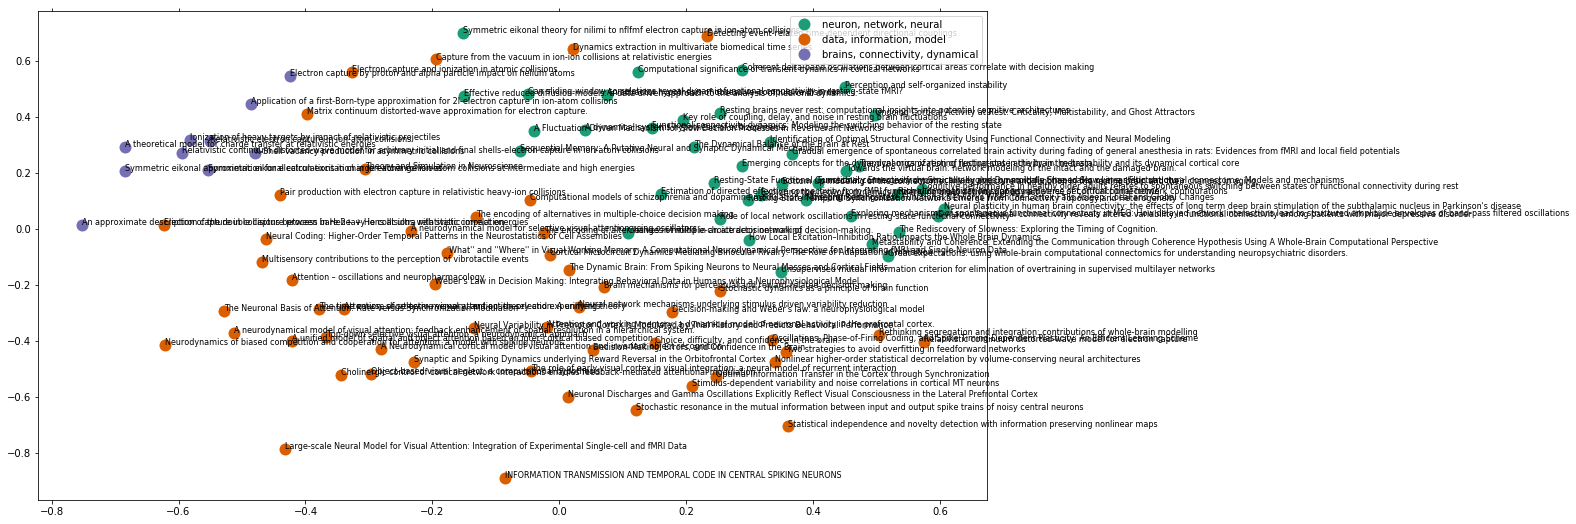

In [22]:

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  #<---- df.ix['title']

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

plt.close()


In [23]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [24]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, 
                     label=cluster_names[name], mec='none', 
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

# Hierarchical clustering

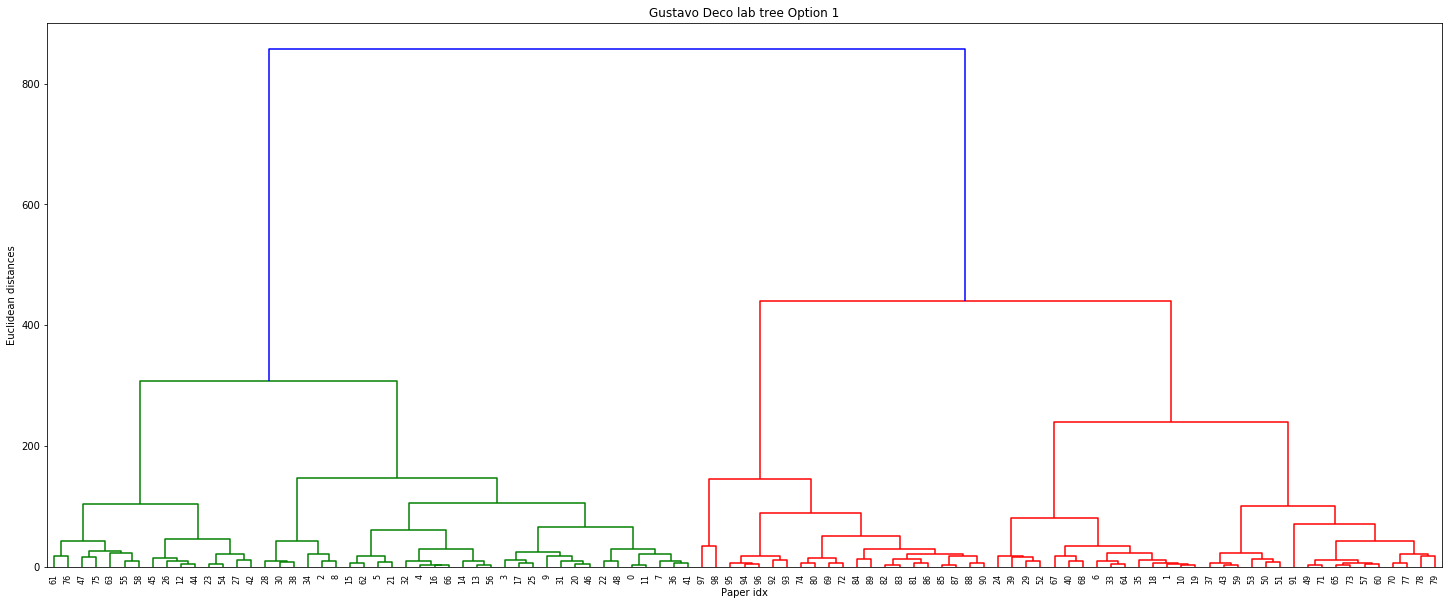

In [34]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
from scipy.cluster.hierarchy import dendrogram, linkage


# generate the linkage matrix
Z = linkage(linkage_matrix, 'ward')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Gustavo Deco lab tree Option 1')
plt.xlabel('Paper idx')
plt.ylabel('Euclidean distances')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

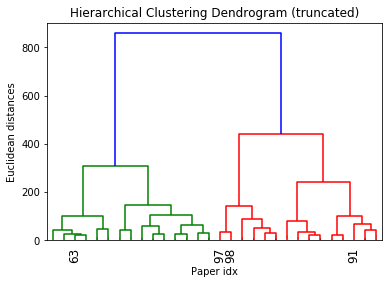

In [36]:
# Truncating my dendogram
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('Paper idx')
plt.ylabel('Euclidean distances')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=30,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

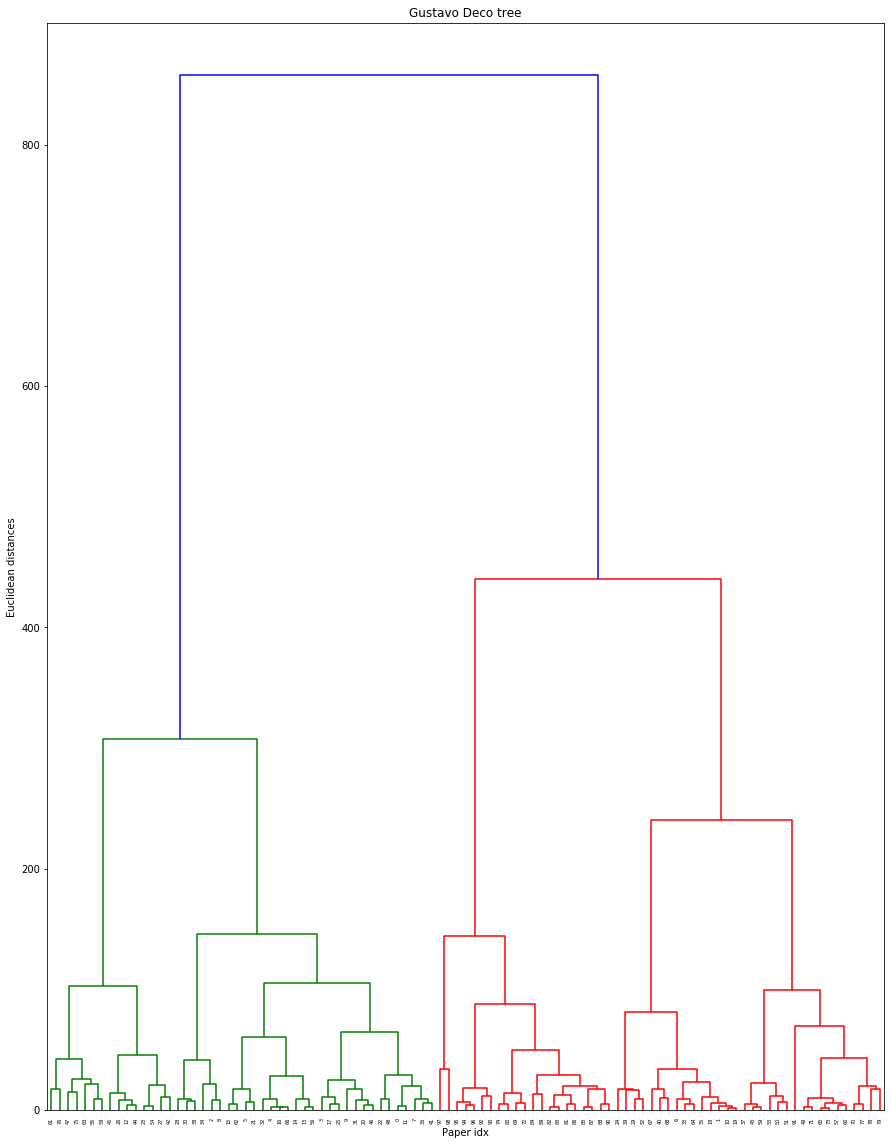

In [37]:
# Using the dendrogram to find the optimal numbers of clusters. 
# https://medium.com/@sametgirgin/hierarchical-clustering-model-in-5-steps-with-python-6c45087d4318

# Ward method is actually a method that tries to minimize the variance within each cluster.
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(15, 20))  
plt.title("Gustavo Deco tree")  
plt.xlabel('Paper idx')
plt.ylabel('Euclidean distances')
dend = shc.dendrogram(shc.linkage(linkage_matrix, method = 'ward'))




<function matplotlib.pyplot.show(*args, **kw)>

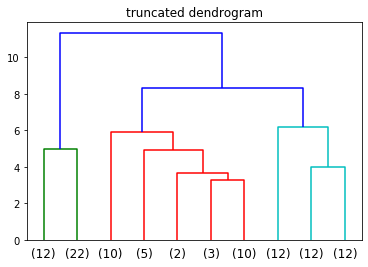

In [38]:
from scipy.cluster.hierarchy import ward, dendrogram

dendrogram(linkage_matrix, truncate_mode='lastp', p=10, labels=titles)
plt.title('truncated dendrogram')
plt.show



In [54]:
# Converting series to list for using as my labels

list_titles = titles.values.tolist()
#print(list_titles) # now transformed into a list 

list_years = years.values.tolist()
print(list_years)

['2011', '2008', '2009', '2012', '2009', '2004', '2011', '2016', '2008', '2005', '2013', '2015', '2015', '2011', '2005', '2013', '2014', '2014', '2006', '2007', '2000', '2011', '1995', '2010', '2003', '2004', '2010', '1996', '2012', '2009', '2014', '2012', '2013', '1997', '2016', '2014', '2014', '2012', '2002', '2004', '2015', '2010', '2013', '2014', '2001', '2012', '2010', '2002', '2007', '2008', '2009', '2017', '2017', '1995', '2013', '2002', '2009', '2015', '2011', '2016', '2007', '2008', '2013', '2016', '2004', '2001', '2014', '2009', '2013', '2005', '2014', '2017', '2009', '1998', '2002', '2001', '2009', '1998', '2011', '2008', '2015', '1988', '1984', '1987', '2006', '1986', '1986', '1997', '1987', '1991', '1986', '1989', '1985', '1986', '1987', '1988', '1989', '1993', '1988', '1989']


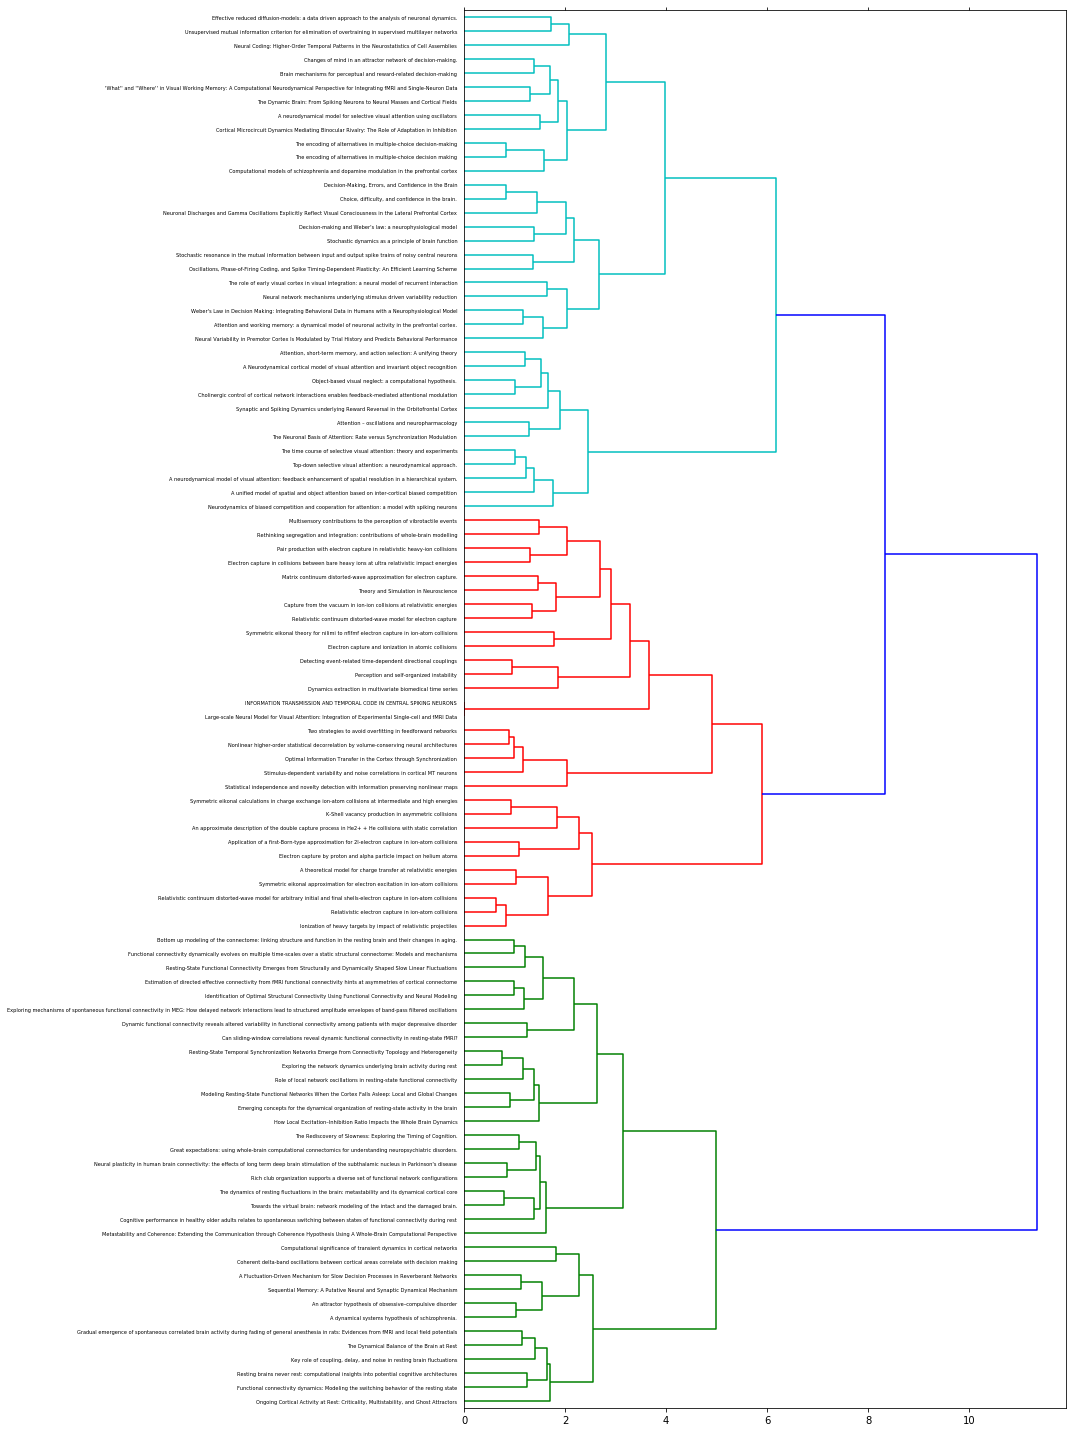

In [55]:
# http://brandonrose.org/clustering#K-means-clustering

from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=list_titles); #<--- issue with labels, they're too long

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('GustavoDeco_labtree.png', dpi=200) #save figure as ward_clusters